# Project 4 

### Objectives
1. Determine the **industry factors** that are _most important_ in predicting the salary amounts for these data.
2. Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?

### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import re
import time

import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split,cross_val_score,  GridSearchCV
from sklearn.linear_model import Ridge,RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score,classification_report,roc_curve, auc
from sklearn.naive_bayes import MultinomialNB


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ngyen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Data and brief EDA

In [3]:
jobs = pd.read_csv('./datasets/webscrape_alljobs_nosalary.csv',index_col=0)

In [4]:
#Checked in question 2
jobs.drop_duplicates(inplace=True)

In [5]:
#Checked in question 2
jobs.reset_index(drop=True,inplace=True)

In [6]:
jobs.head()

,Job_Company,Job_Desc,Job_Salary,Job_Title,Job_employment_type,Min_years,Salary_max,Salary_min,Salary_avg
0,Morgan Stanley,Roles & Responsibilities COMPANY DESCRIPTION ...,4500,Business Analyst,NaN,NaN,4500.0,4500.0,4500.0
1,HP Inc,Roles & Responsibilities Review and understand...,7100,Business Analyst / Business Manager,NaN,NaN,7100.0,7100.0,7100.0
2,Point72,Roles & ResponsibilitiesThe Analyst works toge...,7000,Business Analyst,NaN,NaN,7000.0,7000.0,7000.0
3,Twitter,Roles & Responsibilities\r\n\r\n\r\n\r\n\r\n\r...,4250,Business Analyst,NaN,NaN,4250.0,4250.0,4250.0
4,Henkel,Roles & ResponsibilitiesThe Development Techni...,5000,Technical Leader,NaN,NaN,5000.0,5000.0,5000.0


In [7]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 9 columns):
Job_Company            1482 non-null object
Job_Desc               1485 non-null object
Job_Salary             1485 non-null object
Job_Title              1485 non-null object
Job_employment_type    560 non-null object
Min_years              396 non-null float64
Salary_max             966 non-null float64
Salary_min             966 non-null float64
Salary_avg             966 non-null float64
dtypes: float64(4), object(5)
memory usage: 104.5+ KB


In [8]:
jobs.describe()

,Min_years,Salary_max,Salary_min,Salary_avg
count,396.000000,966.000000,966.000000,966.000000
mean,3.396465,7159.685300,4976.051760,6067.868530
std,1.881795,3362.395179,2221.195777,2694.579541
min,1.000000,1250.000000,1000.000000,1250.000000
25%,2.000000,4900.000000,3500.000000,4000.000000
50%,3.000000,6500.000000,4500.000000,5500.000000
75%,5.000000,9000.000000,6000.000000,7500.000000
max,12.000000,25000.000000,20000.000000,20000.000000


In [9]:
jobs.dropna(subset =['Salary_avg'],inplace = True)

In [10]:
print 'Jobs with Salary higher than $10 000'
for i in jobs[(jobs['Salary_min']>10000)]['Job_Title']:
    print i
print     
print 'Jobs with Salary lower than $1 000'
for i in jobs[(jobs['Salary_min']<1000)]['Job_Title']:
    print i

Jobs with Salary higher than $10 000
Business Intelligence  AI  /  Big Data Strategy Partners - Vice President
Triple A Developer
Lead  /  Senior Data Scientist
Senior Business Analyst
Digital Business Analyst
Vice President, Business Intelligence & Analytics (Big Data  /  Data Management Office)
Market Data Business Analyst  /  Project Manager
Strategy and Insights Analyst, Agency Business Development - Singapore
Data Scientist
Principal Business Analyst- Actimize
Subject-Matter Expert - Trade and Supply Chain Finance
VP, Data Scientist, Business Analytics, Consumer Banking Group (1800016V)
VP, Data Engineer, Asian Insights Office, Group Research (180002PI)
Business Analyst / Project Manager  12 Month Contract (Renewable)
Triple A Developer
Business Analyst
Business Analyst /  Business Manager
Data Engineer
High-Performance Data Engineer
Business Analyst - Regulatory Reporting
Business Analyst
Business Transformation Partner

Jobs with Salary lower than $1 000


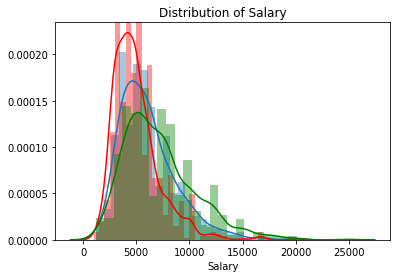

In [11]:
sns.distplot(jobs['Salary_avg'])
sns.distplot(jobs['Salary_min'],color='red')
sns.distplot(jobs['Salary_max'],color = 'green')

plt.title('Distribution of Salary')
plt.xlabel('Salary');

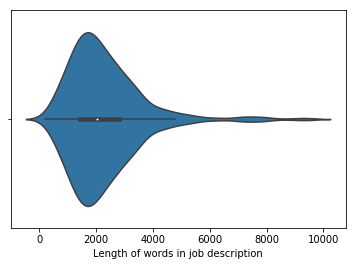

In [322]:
sns.violinplot([len(desc) for desc in jobs['Job_Desc']])
plt.xlabel('Length of words in job description');

### Only using Job_Desc

In [13]:
# to keep track of scores
def obtain_scores(estimator,X_train, y_train, X_test, y_test):
    scores_train = cross_val_score(estimator, X_train, y_train, cv=5)
    score_test = estimator.score(X_test,y_test)
    print 'Mean of scores: {} | Std of scores: {}'.format(np.mean(scores_train), np.std(scores_train))
    print 'Test score: {}'.format(score_test)
    
    return {'mean_score':np.mean(scores_train), 
            'std_score':np.std(scores_train), 
            'for_compare': [np.mean(scores_train),np.std(scores_train),score_test]
           }

# to keep track and add the scores for easy comparison 
def add_model(model_name,summary,df):
    row = pd.DataFrame([model_name]+summary['for_compare'],
                       index=['model','train_mean_score','train_std_score','test_score']).T
    new_df = pd.concat([df,row])
    return new_df


In [22]:
# Clean Job_Desc
X = jobs['Job_Desc']

    
X = X.map(lambda x: re.sub('[^ a-zA-Z]',' ',x).lower())
X = X.map(lambda x: " ".join(x.split())) 

to_replace_list = ['requirements', 'responsibilities','data']
for word in to_replace_list:
    X = X.str.replace(word, word +' ')

ps = PorterStemmer() 
# lemmatizer = WordNetLemmatizer()   
X = X.map(lambda x: ' '.join([ps.stem(word)for word in x.split() if word not in set(stopwords.words('english'))]))


X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    jobs['Salary_avg'], 
                                                    test_size = 0.25, 
                                                    random_state=42)

In [15]:
X_train.sample(5)

366     role respons job overview financi institut fin...
51      role respons support day day oper dwh bi first...
228     role respons million smallhold farm global lea...
1135    role respons design develop test deploy analys...
1129    role respons respons align understand priorit ...
Name: Job_Desc, dtype: object

In [21]:
# Check the time taken to do cvec
start = time.clock()
#your code here    
cvec = CountVectorizer()
cvec.fit_transform(X_train)
print time.clock() - start
print len(cvec.get_feature_names())

0.315673925851
4399


In [17]:
# to check where are the words that are stuck together
# words include: 'responsibilities' etc
for word in cvec.get_feature_names():
    if len(word)>10:
        print word

accordingli
architectur
aryansearch
bioinformat
biotechnolog
bluechipcar
breakthrough
careerlibrari
certissecur
changerequest
citizenship
clearinghous
cloudfoundri
commercialis
conceptualis
contributor
controllership
controllerview
convincingli
counterpart
counterparti
craftsmanship
davidgoliath
deepmangath
development
digitalvalu
disciplinari
discretionari
distinguish
distributor
documentari
easilydigest
effortlessli
elasticcach
elasticsearch
entrepreneur
entrepreneuri
entrepreneurship
environment
exploratori
extracurricular
frictionless
frieslandcampina
groundbreak
importantli
industrialis
inexperienc
informatica
informatician
infrastructur
interconnect
intercultur
interdepend
interdisciplinari
intermediari
internation
interperson
jpmorganchas
kerryconsult
macroeconom
methodolgoi
microservic
microstratagey
microstrategi
microstructur
multicultur
multidisciplinari
multithread
nanosatellit
nonparametr
nsearchglob
omnichannel
openstreetmap
operationalis
pageuppeopl
particularli
partners

## Using regression models to predict Salary amounts 

In [23]:
#Set up empty dataframe to add results for easy comparison
summary = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])

#### Linear/Lasso/Ridge/Elastic Net Regression

In [24]:
# For each regression I run 
start = time.clock()

# define the steps I want in my pipe line
cvec = CountVectorizer()
lasso = Lasso(alpha=100)

#define my pipe and fit my data 
pipe = Pipeline(steps=[('CountVec', cvec),
                       ('lasso',lasso)])
pipe.fit(X_train,y_train)

# Previously defined functions to obtain 'scores' for train and test set 
summary_pipe = obtain_scores(pipe,X_train,y_train,X_test,y_test)
# Previously defined punctions to store all the 'scores' in a dataframe for easy comparison
summary = add_model('basic lasso',summary_pipe,summary)

print "Time taken = {}s".format(time.clock() - start)

Mean of scores: -0.0348974894379 | Std of scores: 0.0279747033358
Test score: 0.0459355120843
Time taken = 2.62992016882s


In [25]:
start = time.clock()

#Variation
cvec = CountVectorizer()
tfidf = TfidfTransformer()
lasso = Lasso(alpha=100)

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('lasso',lasso)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_model('tfidf lasso',summary_pipe,summary)

print "Time taken = {}s".format(time.clock() - start)

Mean of scores: -0.0156110399316 | Std of scores: 0.00970548051922
Test score: -5.74378522249e-05
Time taken = 1.74301400176s


In [26]:
start = time.clock()

#Variation
lr = LinearRegression()
cvec = CountVectorizer()

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('LinearReg', lr)])

pipe.fit(X_train,y_train)
summary_pipe = obtain_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_model('Basic Linear Regression',summary_pipe,summary)

print "Time taken = {}s".format(time.clock() - start)

Mean of scores: -1.06743930716 | Std of scores: 0.367731511445
Test score: -1.14636188441
Time taken = 3.03867573432s


In [27]:
start = time.clock()

#Variation
lr = LinearRegression()
cvec = CountVectorizer(stop_words='english')
tfidf = TfidfTransformer()

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('LinearReg', lr)])

pipe.fit(X_train,y_train)
summary_pipe = obtain_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_model('tfidf Linear Regression',summary_pipe,summary)

print "Time taken = {}s".format(time.clock() - start)

Mean of scores: -0.646027539947 | Std of scores: 0.223740031511
Test score: -0.848384527173
Time taken = 2.64031731304s


In [28]:
start = time.clock()

#Variation
cvec = CountVectorizer()
ridge = Ridge()
tfidf = TfidfTransformer()

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('Ridge', ridge)])

pipe.fit(X_train,y_train)
summary_pipe = obtain_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_model('tfidf Ridge',summary_pipe,summary)

print "Time taken = {}s".format(time.clock() - start)

Mean of scores: -0.0418361753487 | Std of scores: 0.0198231454874
Test score: -0.02369169037
Time taken = 1.93079894817s


In [29]:
start = time.clock()

#Variation
cvec = CountVectorizer(stop_words='english')
ridge = Ridge()

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('Ridge', ridge)])

pipe.fit(X_train,y_train)
summary_pipe = obtain_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_model('basic Ridge',summary_pipe,summary)

print "Time taken = {}s".format(time.clock() - start)

Mean of scores: -0.499783482719 | Std of scores: 0.178237406133
Test score: -0.420566580067
Time taken = 4.92886013224s


In [31]:
start = time.clock()

cvec = CountVectorizer(stop_words='english')
enet = ElasticNet()
tfidf = TfidfTransformer()

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('Enet', enet)])

pipe.fit(X_train,y_train)
summary_pipe = obtain_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_model('tfidf enet',summary_pipe,summary)

print "Time taken = {}s".format(time.clock() - start)

Mean of scores: -0.0133318775556 | Std of scores: 0.00993808232563
Test score: 0.00228045340457
Time taken = 1.9610163542s


In [32]:
start = time.clock()

cvec = CountVectorizer(stop_words='english')
enet = ElasticNet()

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('Enet', enet)])

pipe.fit(X_train,y_train)
summary_pipe = obtain_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_model('basic enet',summary_pipe,summary)

print "Time taken = {}s".format(time.clock() - start)

Mean of scores: -0.0889485476422 | Std of scores: 0.0547860049995
Test score: -0.0542889350822
Time taken = 14.6454738039s


In [34]:
summary.sort_values('train_mean_score',ascending = False)

,model,train_mean_score,train_std_score,test_score
0,tfidf enet,-0.0133319,0.00993808,0.00228045
0,tfidf lasso,-0.015611,0.00970548,-5.74379e-05
0,basic lasso,-0.0348975,0.0279747,0.0459355
0,tfidf Ridge,-0.0418362,0.0198231,-0.0236917
0,basic enet,-0.0889485,0.054786,-0.0542889
0,basic Ridge,-0.499783,0.178237,-0.420567
0,tfidf Linear Regression,-0.646028,0.22374,-0.848385
0,Basic Linear Regression,-1.06744,0.367732,-1.14636


In [38]:
start = time.clock()

cvec = CountVectorizer(max_df = 0.90, min_df=0.1, ngram_range=(1,3))
enet = ElasticNet()
tfidf = TfidfTransformer()

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('enet', enet)])

pipe.fit(X_train,y_train)
summary_pipe = obtain_scores(pipe,X_train,y_train,X_test,y_test)
add_model('tfidf enet cvecV1',summary_pipe,summary)

print "Time taken = {}s".format(time.clock() - start)

Mean of scores: -0.0131440053352 | Std of scores: 0.0100489351266
Test score: 0.00325420120338
Time taken = 9.59461503881s


In [ ]:
start = time.clock()

jdprep = JobDescPreprocessor()
cvec = CountVectorizer(ngram_range=(2,3),stop_words='english')
lasso = Lasso()
tfidf = TfidfTransformer()

pipe = Pipeline(steps=[('JD_prep', jdprep),
                             ('CountVec', cvec),
                             ('tfidf',tfidf),
                             ('lasso', lasso)])

pipe.fit(X_train,y_train)
summary_pipe = obtain_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_model('tfidf lasso cvecV2',summary_pipe,summary)

print "Time taken = {}s".format(time.clock() - start)

In [39]:
start = time.clock()

cvec = CountVectorizer(stop_words='english')
ridge = Ridge()
rfecv = RFECV(ridge, step=10, cv=3)
tfidf = TfidfTransformer()

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('RFECV', rfecv)])

pipe.fit(X_train,y_train)
summary_pipe = obtain_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_model('rfecv Ridge step=10',summary_pipe,summary)

print "Time taken = {}s".format(time.clock() - start)

Mean of scores: -0.0112629157944 | Std of scores: 0.0159670433231
Test score: 0.0405694220853
Time taken = 285.044921205s


In [ ]:
start = time.clock()

jdprep = JobDescPreprocessor()
cvec = CountVectorizer(stop_words='english')
ridge = Ridge()
rfecv = RFECV(ridge, step=100, cv=3)
tfidf = TfidfTransformer()

pipe = Pipeline(steps=[('JD_prep', jdprep),
                             ('CountVec', cvec),
                             ('tfidf',tfidf),
                             ('RFECV', rfecv)])

pipe.fit(X_train,y_train)
summary_pipe = obtain_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_model('rfecv Ridge step=100',summary_pipe,summary)

print "Time taken = {}s".format(time.clock() - start)

In [ ]:
start = time.clock()

jdprep = JobDescPreprocessor()
cvec = CountVectorizer(stop_words='english')
lr = LinearRegression()
rfecv = RFECV(lr, step=10, cv=3)
tfidf = TfidfTransformer()

lr_rfecv_pipe = Pipeline(steps=[('JD_prep', jdprep),
                             ('CountVec', cvec),
                             ('tfidf',tfidf),
                             ('RFECV', rfecv)])

lr_rfecv_pipe.fit(X_train,y_train)
print "Time taken for fit = {}s".format(time.clock() - start)
summary_lr_rfecv_pipe = obtain_scores(lr_rfecv_pipe,X_train,y_train,X_test,y_test)
print "Time taken to score = {}s".format(time.clock() - start)

summary = add_model('rfecv lr',summary_lr_rfecv_pipe ,summary)

In [ ]:
summary

At this point, none of the results is above 0.1, it might be that Regression may not be the best model to predict salary. 
Try using Job_titles only

## Regression Using Job Title only 

In [ ]:
X = jobs['Job_Title']

X = X.replace('vice president', 'vp',regex=True)
X = X.replace('entrepris','enterpris',regex=True)
X = X.map(lambda x: re.sub('[^ a-zA-Z]',' ',x).lower())
X = X.map(lambda x: " ".join(x.split())) 

lemmatizer = WordNetLemmatizer()    
X = X.map(lambda x: ' '.join([lemmatizer.lemmatize(word)for word in x.split()]))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    jobs['Salary_avg'], 
                                                    test_size = 0.2, 
                                                    random_state=42)

In [ ]:
cvec = CountVectorizer()
cvec.fit_transform(X_train)
print len(cvec.get_feature_names())
print cvec.get_feature_names()

In [ ]:
cvec = CountVectorizer(stop_words='english')
ridge = Ridge()
tfidf = TfidfTransformer()

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('Ridge', ridge)])

pipe.fit(X_train,y_train)
summary_pipe = obtain_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_model('basic Ridge',summary_pipe,summary)

At this point it can be seen that none of the regression models are good 
For some results, I decided to do a quick classification model instead. 

# Classification

In [40]:
jobs.describe()

,Min_years,Salary_max,Salary_min,Salary_avg
count,211.000000,966.000000,966.000000,966.000000
mean,3.379147,7159.685300,4976.051760,6067.868530
std,1.772365,3362.395179,2221.195777,2694.579541
min,1.000000,1250.000000,1000.000000,1250.000000
25%,2.000000,4900.000000,3500.000000,4000.000000
50%,3.000000,6500.000000,4500.000000,5500.000000
75%,5.000000,9000.000000,6000.000000,7500.000000
max,12.000000,25000.000000,20000.000000,20000.000000


In [41]:
np.percentile(jobs['Salary_avg'],25)

4000.0

In [141]:
# label 0 (low salary) is less than median
# label 1 (high salary) is above median
jobs['Salary_class'] =  [0 if salary <= np.percentile(jobs['Salary_avg'],50) else
                         1 for salary in jobs['Salary_avg']]

In [204]:
# Define a different function to obtain classification scores 
def obtain_class_scores(estimator,X_train, y_train, X_test, y_test,threshold = 0.5):
    #Trees predict probabilities
    if len(set(estimator.predict(X_test)))>2 or (1 not in set(estimator.predict(X_test)) or 0 not in set(estimator.predict(X_test))):
        y_pred = [1 if i>threshold else 0 for i in pipe.predict(X_test)]
    else: 
         y_pred = estimator.predict(X_test)
    
    accuracy = np.mean(accuracy_score(y_test, y_pred))
    recall = np.mean(recall_score(y_test, y_pred,average=None))
    precision = np.mean(precision_score(y_test, y_pred,average=None))
    F1 = 2*(precision*recall)/(precision+recall)
    confusion = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                             index=['is_0','is_1'],
                             columns=['pred_0','pred_1'])    
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    
    print classification_report(y_test, y_pred)
    return {'confusion matrix': confusion,
            'roc':roc_auc,
            'for_compare': [accuracy,recall,precision,F1,roc_auc]
           }

def add_class_model(model_name,summary,df):
    row = pd.DataFrame([model_name]+summary['for_compare'],
                       index=['model','accuracy','recall_DS','precision_DS','F1_score_DS','ROC']).T
    new_df = pd.concat([df,row])
    return new_df

In [72]:
X = jobs['Job_Desc']

    
X = X.map(lambda x: re.sub('[^ a-zA-Z]',' ',x).lower())
X = X.map(lambda x: " ".join(x.split())) 

to_replace_list = ['requirements', 'responsibilities','data']
for word in to_replace_list:
    X = X.str.replace(word, word +' ')

ps = PorterStemmer() 
# lemmatizer = WordNetLemmatizer()   
X = X.map(lambda x: ' '.join([ps.stem(word)for word in x.split() if word not in set(stopwords.words('english'))]))


In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    jobs['Salary_class'], 
                                                    test_size = 0.2, 
                                                    random_state=42)

In [144]:
print X_train.sample(5)
print y_train.sample(5)

831     role respons job summari hire busi analyst joi...
784     role respons engin bioscienc ventur back biote...
1040    role respons vanc group ltd vanc group diversi...
685     role respons look busi analyst minimum yr expe...
399     role respons busi function group audit help bo...
Name: Job_Desc, dtype: object
246     0
590     1
1192    0
841     1
1267    1
Name: Salary_class, dtype: int64


In [145]:
#Set up empty dataframe to add results for easy comparison
summary = pd.DataFrame(columns=['model','accuracy','recall_DS','precision_DS','F1_score_DS','ROC'])

### Try Logisitic Regression

In [148]:
cvec = CountVectorizer()
logreg = LogisticRegression(penalty='l2')

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('logreg',logreg)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_class_model('basic logreg penalty l2',summary_pipe,summary)

summary_pipe ['confusion matrix']

             precision    recall  f1-score   support

          0       0.54      0.53      0.54       101
          1       0.50      0.51      0.50        93

avg / total       0.52      0.52      0.52       194



,pred_0,pred_1
is_0,54,47
is_1,46,47


In [190]:
cvec = CountVectorizer()
tfidf = TfidfTransformer()
logreg = LogisticRegression(penalty='l2')

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('logreg',logreg)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_class_model('basic logreg penalty l2',summary_pipe,summary)

summary_pipe ['confusion matrix']

             precision    recall  f1-score   support

          0       0.58      0.59      0.59       101
          1       0.54      0.53      0.54        93

avg / total       0.56      0.56      0.56       194



,pred_0,pred_1
is_0,60,41
is_1,44,49


In [149]:
cvec = CountVectorizer()
logreg = LogisticRegression(penalty='l1')

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('logreg',logreg)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_class_model('tfidf logreg penalty l1',summary_pipe,summary)

summary_pipe ['confusion matrix']

             precision    recall  f1-score   support

          0       0.56      0.54      0.55       101
          1       0.52      0.53      0.52        93

avg / total       0.54      0.54      0.54       194



,pred_0,pred_1
is_0,55,46
is_1,44,49


In [192]:
cvec = CountVectorizer()
tfidf = TfidfTransformer()
logreg = LogisticRegression(penalty='l1')

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('logreg',logreg)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_class_model('tfidf logreg penalty l2',summary_pipe,summary)

summary_pipe ['confusion matrix']

             precision    recall  f1-score   support

          0       0.56      0.50      0.53       101
          1       0.51      0.57      0.54        93

avg / total       0.54      0.54      0.54       194



,pred_0,pred_1
is_0,51,50
is_1,40,53


In [106]:
gs_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100),
    'tol':np.logspace(-5,0,10)
}

lr_gridsearch = GridSearchCV(LogisticRegression(), gs_params, cv=5, verbose=1)
lr_gridsearch.fit(cvec.fit_transform(X_train), y_train)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:  7.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e-05, 1.12332e-05, ..., 8.90215e-01, 1.00000e+00]), 'tol': array([1.00000e-05, 3.59381e-05, 1.29155e-04, 4.64159e-04, 1.66810e-03,
       5.99484e-03, 2.15443e-02, 7.74264e-02, 2.78256e-01, 1.00000e+00]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [107]:
lr_gridsearch.best_estimator_

LogisticRegression(C=0.00016297508346206434, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.2782559402207126, verbose=0,
          warm_start=False)

In [150]:
cvec = CountVectorizer()
logreg = LogisticRegression(C=0.00016297508346206434, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.2782559402207126, verbose=0,
          warm_start=False)

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('logreg',logreg)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_class_model('gridsearch logreg',summary_pipe,summary)

summary_pipe ['confusion matrix']

             precision    recall  f1-score   support

          0       0.64      0.34      0.44       101
          1       0.52      0.80      0.63        93

avg / total       0.59      0.56      0.53       194



,pred_0,pred_1
is_0,34,67
is_1,19,74


In [195]:
pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf)])

gs_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100),
    'tol':np.logspace(-5,0,10)
}

lr_gridsearch = GridSearchCV(LogisticRegression(), gs_params, cv=5, verbose=1)
lr_gridsearch.fit(pipe.fit_transform(X_train), y_train)
lr_gridsearch.best_estimator_

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:  2.0min finished


LogisticRegression(C=0.09770099572992247, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.2782559402207126, verbose=0,
          warm_start=False)

In [196]:
cvec = CountVectorizer()
tfidf = TfidfTransformer()
logreg = LogisticRegression(C=0.09770099572992247, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.2782559402207126, verbose=0,
          warm_start=False)

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('logreg',logreg)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_class_model('tfidf logreg penalty gridsearch',summary_pipe,summary)

summary_pipe ['confusion matrix']

             precision    recall  f1-score   support

          0       0.57      0.56      0.57       101
          1       0.53      0.54      0.53        93

avg / total       0.55      0.55      0.55       194



,pred_0,pred_1
is_0,57,44
is_1,43,50


### Try Naive Bayes

In [ ]:
cvec = CountVectorizer()
bayes = MultinomialNB()

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('bayes',bayes)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_class_model('bayes',summary_pipe,summary)

summary_pipe ['confusion matrix']

In [197]:
cvec = CountVectorizer()
tfidf = TfidfTransformer()
bayes = MultinomialNB()

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('bayes',bayes)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_class_model('tfidf bayes',summary_pipe,summary)

summary_pipe ['confusion matrix']

             precision    recall  f1-score   support

          0       0.58      0.57      0.58       101
          1       0.54      0.55      0.55        93

avg / total       0.56      0.56      0.56       194



,pred_0,pred_1
is_0,58,43
is_1,42,51


### Try Decision Tree

In [198]:
cvec = CountVectorizer()
tree = DecisionTreeClassifier(random_state=0)

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('decision tree',tree)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_class_model('decision tree',summary_pipe,summary)

summary_pipe ['confusion matrix']


             precision    recall  f1-score   support

          0       0.55      0.64      0.59       101
          1       0.53      0.43      0.47        93

avg / total       0.54      0.54      0.54       194



,pred_0,pred_1
is_0,65,36
is_1,53,40


In [199]:
cvec = CountVectorizer()
tfidf = TfidfTransformer()
tree = DecisionTreeClassifier(random_state=0)

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('decision tree',tree)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_class_model('tfidf decision tree',summary_pipe,summary)

summary_pipe ['confusion matrix']


             precision    recall  f1-score   support

          0       0.54      0.65      0.59       101
          1       0.51      0.39      0.44        93

avg / total       0.52      0.53      0.52       194



,pred_0,pred_1
is_0,66,35
is_1,57,36


In [178]:
tree_params = {
    'max_depth':range(1,21),
    'min_samples_split':range(2,22,5),
    'min_samples_leaf':range(1,21,5),
}

tree_gridsearch = GridSearchCV(DecisionTreeRegressor(), tree_params)
tree_gridsearch.fit(cvec.fit_transform(X_train), y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 7, 12, 17], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'min_samples_leaf': [1, 6, 11, 16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [179]:
tree_gridsearch.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [188]:
cvec = CountVectorizer()
tree = DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
                               max_leaf_nodes=None, min_impurity_decrease=0.0,
                               min_impurity_split=None, min_samples_leaf=1,
                               min_samples_split=2, min_weight_fraction_leaf=0.0,
                               presort=False, random_state=None, splitter='best')

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('decision tree',tree)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_class_model('decision tree gridsearch',summary_pipe,summary)

summary_pipe ['confusion matrix']


             precision    recall  f1-score   support

          0       0.53      0.99      0.69       101
          1       0.83      0.05      0.10        93

avg / total       0.68      0.54      0.41       194



,pred_0,pred_1
is_0,100,1
is_1,88,5


In [201]:
summary.sort_values('ROC',ascending = False)

,model,accuracy,recall_DS,precision_DS,F1_score_DS,ROC
0,gridsearch logreg,0.556701,0.566166,0.583166,0.57454,0.566166
0,tfidf bayes,0.561856,0.561322,0.561277,0.561299,0.561322
0,basic logreg penalty l2,0.561856,0.560471,0.560684,0.560577,0.560471
0,tfidf logreg penalty gridsearch,0.551546,0.550995,0.550957,0.550976,0.550995
0,bayes,0.541237,0.540243,0.540281,0.540262,0.540243
0,tfidf logreg penalty l2,0.536082,0.537421,0.537501,0.537461,0.537421
0,decision tree,0.541237,0.536836,0.538582,0.537707,0.536836
0,decision tree,0.541237,0.536836,0.538582,0.537707,0.536836
0,basic logreg penalty l1,0.536082,0.535718,0.535673,0.535695,0.535718
0,decision tree gridsearch,0.541237,0.521931,0.682624,0.591559,0.521931


based on the summary, it can be seen that logreg actually does deliver relatively good results (based on ROC and others) 
Next step is to fine tune logreg by changing the parameters of cvec
#### Fine Tuning

In [229]:
cvec = CountVectorizer(max_df=0.95,min_df=0.05,ngram_range=(1,3))
tfidf = TfidfTransformer()
logreg = LogisticRegression(penalty='l1')

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('logreg',logreg)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_class_model('tfidf logreg l1 var1',summary_pipe,summary)
print 'roc score is ' + str(summary_pipe['roc'])
summary_pipe['confusion matrix']

             precision    recall  f1-score   support

          0       0.62      0.55      0.58       101
          1       0.56      0.62      0.59        93

avg / total       0.59      0.59      0.59       194

roc score is 0.5890556797615245


,pred_0,pred_1
is_0,56,45
is_1,35,58


In [230]:
cvec = CountVectorizer(max_df=0.85,min_df=0.2,ngram_range=(1,3))
tfidf = TfidfTransformer()
logreg = LogisticRegression(penalty='l2')

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('logreg',logreg)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
summary = add_class_model('tfidf logreg l2 var1',summary_pipe,summary)
print 'roc score is ' + str(summary_pipe['roc'])
summary_pipe['confusion matrix']

             precision    recall  f1-score   support

          0       0.60      0.58      0.59       101
          1       0.56      0.58      0.57        93

avg / total       0.58      0.58      0.58       194

roc score is 0.5824017885659534


,pred_0,pred_1
is_0,59,42
is_1,39,54


The Results for both is now slightly better 
Let us examine the coefficients 

In [255]:
cvec = CountVectorizer(max_df=0.85,min_df=0.2,ngram_range=(1,3))
tfidf = TfidfTransformer()
logreg = LogisticRegression(penalty='l2')

X_train_new = cvec.fit_transform(X_train)
X_train_new = tfidf.fit_transform(X_train_new)
logreg.fit(X_train_new,y_train)

pd.DataFrame([abs(logreg.coef_[0]),logreg.coef_[0]],
             columns=cvec.get_feature_names(),
             index=['abs_coefficient','coefficent']).T.sort_values('abs_coefficient',ascending=False)

,abs_coefficient,coefficent
maintain,1.323646,-1.323646
abl,1.195016,-1.195016
job,1.010309,-1.010309
end,1.001971,1.001971
risk,0.897840,0.897840
profici,0.872304,-0.872304
market,0.868136,-0.868136
report,0.859673,-0.859673
global,0.845336,0.845336
appli,0.831517,0.831517


In [254]:
cvec = CountVectorizer(max_df=0.95,min_df=0.05,ngram_range=(1,3))
tfidf = TfidfTransformer()
logreg = LogisticRegression(penalty='l1')

X_train_new = cvec.fit_transform(X_train)
X_train_new = tfidf.fit_transform(X_train_new)
logreg.fit(X_train_new,y_train)

pd.DataFrame([abs(logreg.coef_[0]),logreg.coef_[0]],columns=cvec.get_feature_names(),index=['abs_coefficient','coefficent']).T.sort_values('abs_coefficient',ascending=False)

,abs_coefficient,coefficent
center,2.048060,-2.048060
data analyst,1.916950,-1.916950
end,1.362914,1.362914
ms,1.351309,-1.351309
subject,1.317661,1.317661
experi,1.161779,1.161779
market,1.065140,-1.065140
maintain,1.016789,-1.016789
report,0.988406,-0.988406
test,0.960364,0.960364


#### Insights 
For log reg with l1 penalty
- Using this model made sense as some of the features have been set to 0 due to penalization 
- Some of the features makes sense, e.g. data analyst, ms, experi, risk 
- However, some of the features do not make sense, e.g. center (which has the highest coefficient), end, ms etc 
- If more time is given, I would examine and increase the number of 'stopwords' 

Instead of focussing on Job Description, let's try out Classification using Job_title
### Classification using Job_title 

In [289]:
stop = list(set(stopwords.words('english'))) + ['center']

In [293]:
# set up X
X = jobs['Job_Title']

X = X.replace('vice president', 'vp',regex=True)
X = X.replace('entrepris','enterpris',regex=True)
X = X.map(lambda x: re.sub('[^ a-zA-Z]',' ',x).lower())
X = X.map(lambda x: " ".join(x.split())) 

ps = PorterStemmer() 
X = X.map(lambda x: ' '.join([ps.stem(word)for word in x.split() if word not in stop]))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    jobs['Salary_class'], 
                                                    test_size = 0.2, 
                                                    random_state=42)

In [280]:
#Set up empty dataframe to add results for easy comparison
summary_job_title = pd.DataFrame(columns=['model','accuracy','recall_DS','precision_DS','F1_score_DS','ROC'])

In [296]:
cvec = CountVectorizer(ngram_range=(1,3))
tfidf = TfidfTransformer()
logreg = LogisticRegression(penalty='l1')

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('logreg',logreg)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
summary_job_title = add_class_model('basic logreg penalty l1',summary_pipe,summary_job_title)
print summary_pipe['roc']
summary_pipe ['confusion matrix']

             precision    recall  f1-score   support

          0       0.56      0.50      0.52       101
          1       0.51      0.57      0.54        93

avg / total       0.53      0.53      0.53       194

0.5324709890343873


,pred_0,pred_1
is_0,50,51
is_1,40,53


In [297]:
cvec = CountVectorizer(ngram_range=(1,3))
tfidf = TfidfTransformer()
logreg = LogisticRegression(penalty='l1')

X_train_new = cvec.fit_transform(X_train)
X_train_new = tfidf.fit_transform(X_train_new)
logreg.fit(X_train_new,y_train)

pd.DataFrame([abs(logreg.coef_[0]),logreg.coef_[0]],columns=cvec.get_feature_names(),index=['abs_coefficient','coefficent']).T\
  .sort_values('abs_coefficient',ascending=False).head(20)

,abs_coefficient,coefficent
intellig,1.513186,-1.513186
data analyst,0.750527,-0.750527
engin,0.730714,-0.730714
senior data,0.706495,0.706495
tripl,0.466425,0.466425
junior,0.456931,-0.456931
research,0.356613,-0.356613
scientist,0.337464,0.337464
busi,0.304091,-0.304091
senior busi,0.274173,-0.274173


In [312]:
cvec = CountVectorizer(max_df=0.9,min_df=0.2, ngram_range=(1,2))
tfidf = TfidfTransformer()
logreg = LogisticRegression(penalty='l2')

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('logreg',logreg)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
summary_job_title = add_class_model('basic logreg penalty l1',summary_pipe,summary_job_title)
print summary_pipe['roc']
summary_pipe ['confusion matrix']

             precision    recall  f1-score   support

          0       0.66      0.41      0.50       101
          1       0.55      0.77      0.64        93

avg / total       0.61      0.58      0.57       194

0.5900670712232514


,pred_0,pred_1
is_0,41,60
is_1,21,72


In [313]:
cvec = CountVectorizer(max_df=0.9,min_df=0.2, ngram_range=(1,2))
tfidf = TfidfTransformer()
logreg = LogisticRegression(penalty='l2')

X_train_new = cvec.fit_transform(X_train)
X_train_new = tfidf.fit_transform(X_train_new)
logreg.fit(X_train_new,y_train)

pd.DataFrame([abs(logreg.coef_[0]),logreg.coef_[0]],columns=cvec.get_feature_names(),index=['abs_coefficient','coefficent']).T\
  .sort_values('abs_coefficient',ascending=False).head(20)

,abs_coefficient,coefficent
busi analyst,0.464846,0.464846
busi,0.255681,-0.255681
analyst,0.169274,-0.169274
data,0.080552,0.080552


#### Insights 
Model: logreg, penalty l2, max_df=0.9,min_df=0.2, ngram_range=(1,2)
- The score is the highest for logreg penalty l2, limiting max_df and min_df 
- Upon closer inspection of the coefficient, it turns out that only business analyst, business, analyst and data these four words will affect. However, this would skew the prediction to predict all the jobs with business analyst as higher salary which is too generalized (underfitting)  

Model: logreg, penalty l1, 
- the coefficents for this model makes more sense even if ROC is lower
- Words such as intelligence,senior data, scientist affect the salary positively while 
- Words such as data analyst, junior affect the salary negatively 

### Classification on both job title and job desc

In [275]:
X = jobs['Job_Title'] + ' ' +jobs['Job_Desc']

X = X.replace('vice president', 'vp',regex=True)
X = X.replace('entrepris','enterpris',regex=True)
X = X.map(lambda x: re.sub('[^ a-zA-Z]',' ',x).lower())
X = X.map(lambda x: " ".join(x.split())) 

to_replace_list = ['requirements', 'responsibilities','data']
for word in to_replace_list:
    X = X.str.replace(word, word +' ')
    
ps = PorterStemmer() 
X = X.map(lambda x: ' '.join([ps.stem(word)for word in x.split()]))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    jobs['Salary_class'], 
                                                    test_size = 0.2, 
                                                    random_state=42)

In [278]:
cvec = CountVectorizer(max_df=0.95,min_df=0.05,ngram_range=(1,3),stop_words='english')
tfidf = TfidfTransformer()
logreg = LogisticRegression(penalty='l1')

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('logreg',logreg)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
add_class_model('tfidf logreg l1 var1',summary_pipe,summary)
print 'roc score is ' + str(summary_pipe['roc'])
summary_pipe['confusion matrix']

             precision    recall  f1-score   support

          0       0.56      0.53      0.55       101
          1       0.52      0.54      0.53        93

avg / total       0.54      0.54      0.54       194

roc score is 0.5361439369743426


,pred_0,pred_1
is_0,54,47
is_1,43,50


In [320]:
cvec = CountVectorizer(max_df=0.85,min_df=0.2,ngram_range=(1,3),stop_words='english')
tfidf = TfidfTransformer()
logreg = LogisticRegression(penalty='l2')

pipe = Pipeline(steps=[('CountVec', cvec),
                       ('tfidf',tfidf),
                       ('logreg',logreg)])
pipe.fit(X_train,y_train)
summary_pipe = obtain_class_scores(pipe,X_train,y_train,X_test,y_test)
add_class_model('tfidf logreg l1 var1',summary_pipe,summary)
print 'roc score is ' + str(summary_pipe['roc'])
summary_pipe['confusion matrix']

             precision    recall  f1-score   support

          0       0.64      0.38      0.47       101
          1       0.53      0.77      0.63        93

avg / total       0.59      0.57      0.55       194

roc score is 0.5752155860747364


,pred_0,pred_1
is_0,38,63
is_1,21,72


## Conclusions
- Regression did not work as well as we hoped
- Classifcation model's ROC value is around 0.56-0.59
- The words analyst generally have a negtive on the salary as the words appear both in the analysis on Job_Desc and Job_title
- The model using Job_title makes more sense as coefficients words like senior is positive while coefficents like junior is negative, which shows that the higher rank the more the salary pay there is
- The actual better model would be determined by the business problem (see bonus problem) 


## For future actions 
- see if can obtain minimum number of years from the job description as a feature 
- see if can obtain level of role (e.g. leader, vp, senior, junior, intern) and rank them as a feature

### BONUS PROBLEM

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

*The ideal model would have a higher recall for 0 (lower salary) or to edit the threshhold such that the recall for 0 is higher *